# 7.1 K fitting tool

//Mathieu: if you have data for K reduction as function of time, use this tool to fit the data and determine the A1, A2, A3, A4 parameters.

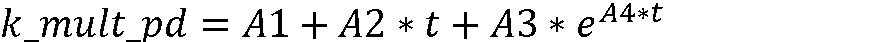

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [13]:
def func(t, A1, A2, A3, A4):
    return A1+A2*t+A3*np.exp(A4*t)

with aid of ChatGPT:

Optimal parameter values:
A1: 0.51298520331305
A2: -2.690148126670144e-08
A3: 0.28297479686057875
A4: -3.908191380615166e-05


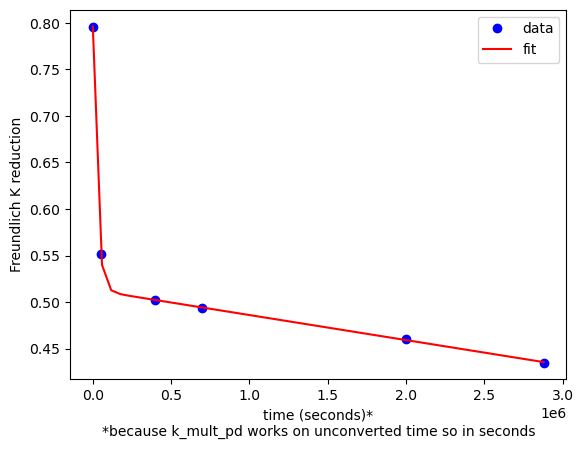

In [14]:
#//Mathieu: indicate how long simulation lasts
time_bounds = np.linspace(0, 2880000, 50) #time is not in days but in seconds, up to maximum (2880000 s = 2000 days)

############################################################################### insert your datapoints here:
time_data = np.array([0, 50000, 400000, 700000, 2000000, 2880000])
Kmult_data = np.array([0.79596, 0.551735552, 0.50207, 0.494, 0.46, 0.435])
###############################################################################

#//Mathieu: help the fit function by giving realistic values for fitting constanst A1-A4 in p0

plt.plot(time_data, Kmult_data, 'bo', label='data')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])
popt
plt.plot(time_bounds, func(time_bounds, *popt), 'r-',
         label='fit')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])

# Print the optimal parameter values
print("Optimal parameter values:")
print("A1:", popt[0])
print("A2:", popt[1])
print("A3:", popt[2])
print("A4:", popt[3])

plt.xlabel('time (seconds)*\n*because k_mult_pd works on unconverted time so in seconds')
plt.ylabel('Freundlich K reduction')
plt.legend()
plt.show()

## Feed PSDM_Kfit.py with fitted function

Ctrl+F: //Mathieu Kfittingtool:

In [15]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM_Kfit
os.chdir(srt_dir)

In [16]:
fn = '7.1_Input_PFHpA.xlsx'

chem_data = PSDM_Kfit.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [17]:
raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  0.51298520331305
rk2:  -2.690148126670144e-08
rk3:  0.28297479686057875
rk4:  -3.908191380615166e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0


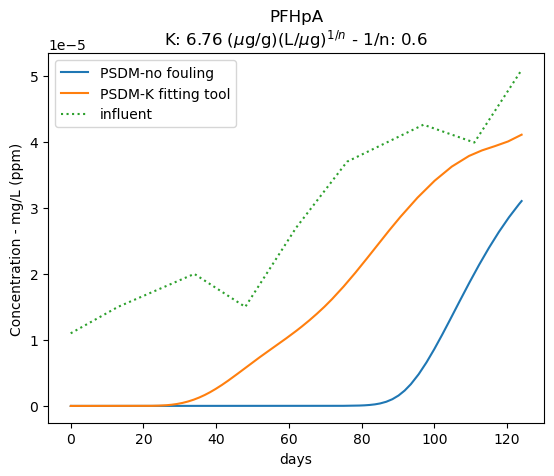

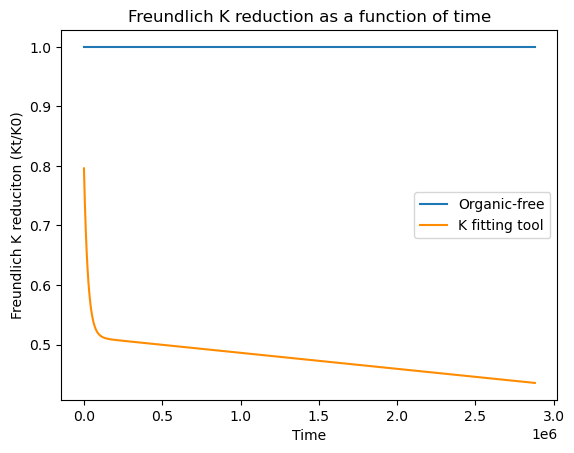

In [18]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed chem_type and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,   #still needed somehow
                   water_type=water_type, #still needed somehow                           
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='Organic-free')     
    plt.plot(column.K_time, 
             column.K_mult_time,
             label='K fitting tool',
             color='darkorange')
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

## Compare K fitting tool with BTC article (darkgreen)
(where K reduction is calculated)

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  0.51298520331305
rk2:  -2.690148126670144e-08
rk3:  0.28297479686057875
rk4:  -3.908191380615166e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


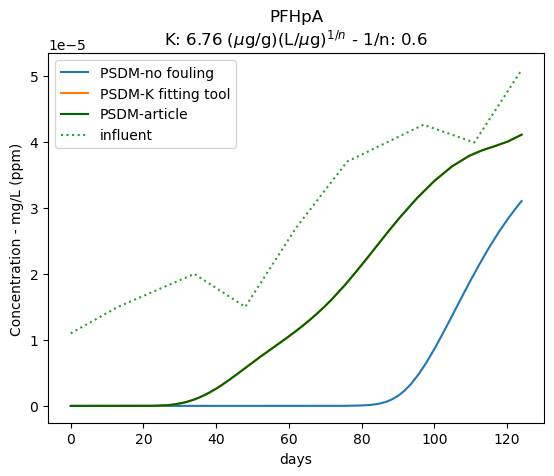

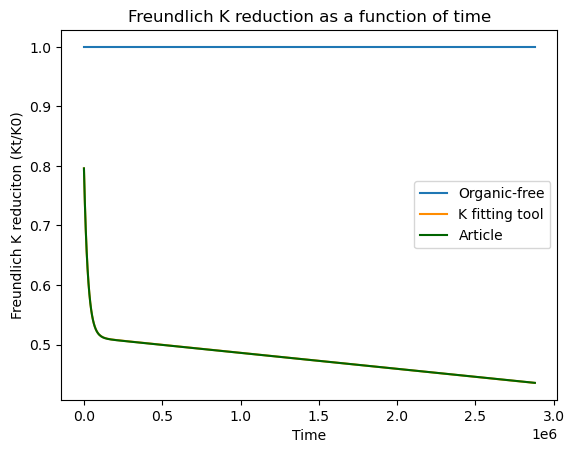

In [19]:
for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,   #still needed somehow
                   water_type=water_type, #still needed somehow                           
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,   #still needed somehow
                   water_type=water_type, #still needed somehow 
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='Organic-free')     
    plt.plot(column.K_time, 
             column.K_mult_time,
             label='K fitting tool',
             color='darkorange')
    plt.plot(column3.K_time, 
             column3.K_mult_time,
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  